In [7]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import cftime
import os
import glob
import netCDF4 as nc
from matplotlib import cm
from mpl_toolkits import basemap
from mpl_toolkits.basemap import Basemap,maskoceans
import pandas as pd

In [8]:
def plt2D(fig, ax, x, y, z, z1=[0], cmap=cm.viridis, levels=np.linspace(0, 40, 11), levels1=[35., 40., 45.],
          title='', ylabel='', zlabel='Pressure (hPa)', xlabel=False, 
          cbar=True, extend='both', fontsize=12, 
          yrange=[1000., 700.], xrange=[-6, 6],
          plotregion=False):
    
    # Create a filled contour plot for the main variable z
    oax = ax.contourf(x, y, z, cmap=cmap, levels=levels, extend=extend)
    
    # Optionally overlay contour lines for a secondary variable z1
    if np.size(z1) > 1:
        CS = ax.contour(x, y, z1, levels=levels1, colors='black', linewidths=0.4)
        plt.clabel(CS, fontsize=7, inline=1, fmt='%2.0f')  # Add labels to contour lines
        
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    
    ax.set_ylabel(ylabel, fontsize=fontsize) 
    if xlabel:
        ax.set_xlabel('Distance from ice edge \n ($\degree$ latitude)', fontsize=fontsize) 
    ax.set_title(title, fontsize=fontsize)
    
    # Add vertical line at ice edge
    ax.axvline(x=0., color='black', lw=0.5, linestyle='--')
    
    # Optionally add vertical lines to indicate a specific region
    if plotregion:
        ax.axvline(x=-2., color='grey', lw=0.5, linestyle='--')
        ax.axvline(x=2., color='grey', lw=0.5, linestyle='--')
    
    # Add a colorbar if requested
    if cbar:
        cbar = fig.colorbar(oax, ax=ax, orientation='vertical', shrink=0.8, aspect=15, 
                            ticks=[levels.min(), levels.max()])
        cbar.set_label(zlabel, fontsize=0.8*fontsize)
    
    return oax  # Return the contourf object

Using 9 models: ['CCCma', 'CNRM', 'E3SM', 'E3SMHiRes', 'GFDL', 'IPSL6', 'MIROC', 'MRI', 'NCAR']


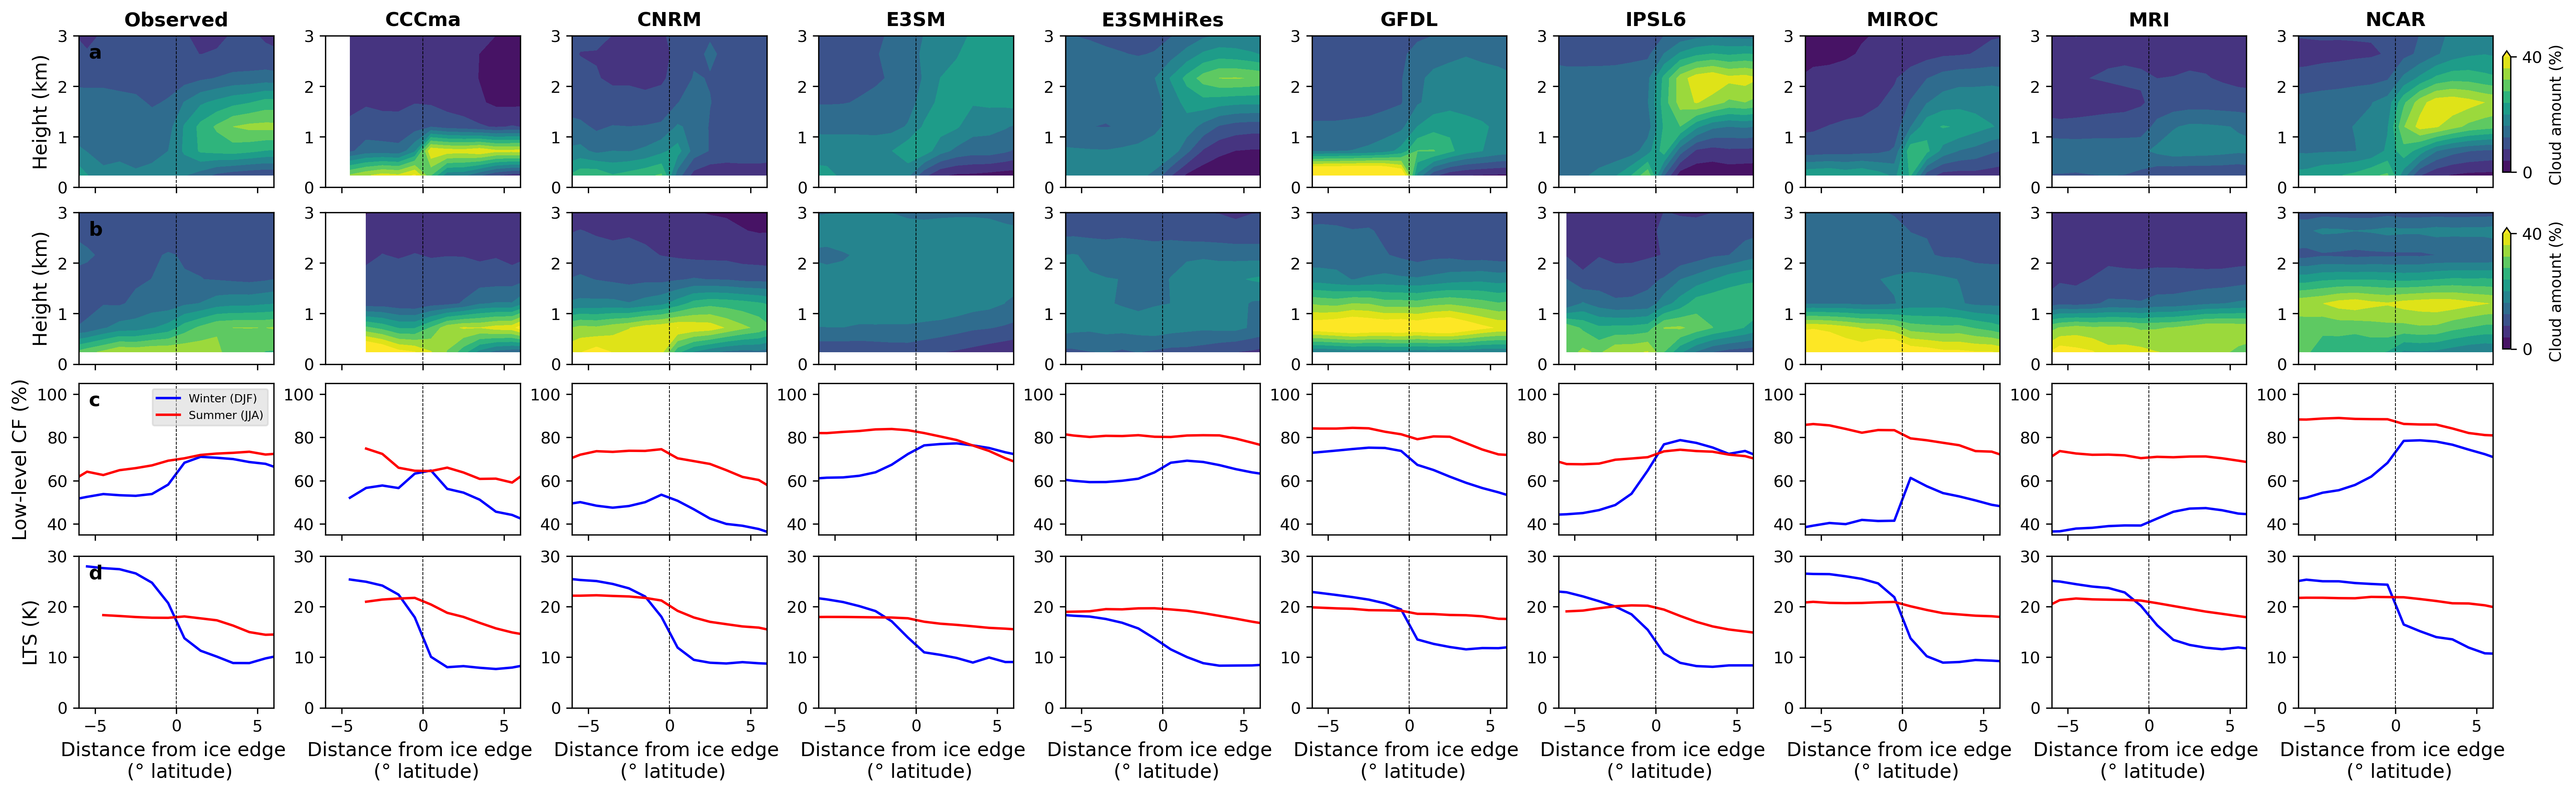

In [10]:
# === Directories ===
dir_2d = "/home/rcostell/Model_Files/CMIP6/Historical/Paper_Files/Binned_2D_Meteorology"
dir_3d = "/home/rcostell/Model_Files/CMIP6/Historical/Paper_Files/Binned_3D_Meteorology"
dir_obs = "/home/rcostell/Observation_Files/Paper_Files/Meteorology"

# === Collect all available model files with new naming ===
files_2d = sorted(glob.glob(os.path.join(dir_2d, "*_Binned_2D_Meteorology.nc")))
files_3d = sorted(glob.glob(os.path.join(dir_3d, "*_Binned_3D_Meteorology.nc")))

# Extract model names automatically from filenames
models_2d = [os.path.basename(f).split("_")[0] for f in files_2d]  # model is first part
models_3d = [os.path.basename(f).split("_")[0] for f in files_3d]

# Find intersection so only models present in BOTH 2D and 3D folders are used
common_models = sorted(set(models_2d).intersection(models_3d))

print(f"Using {len(common_models)} models: {common_models}")

# === Observational data ===
obs_2d = xr.open_dataset(os.path.join(dir_obs, "CALIPSO_Binned_2D_CF.nc")).groupby("time.season").mean()
obs_3d_cl = xr.open_dataset(os.path.join(dir_obs, "CALIPSO_Binned_3D_CF.nc")).groupby("time.season").mean()
obs_3d_ta = xr.open_dataset(os.path.join(dir_obs, "CALIPSO_Binned_3D_Ta.nc")).groupby("time.season").mean()

# Compute Lower Tropospheric Stability (LTS) for observed data
pres = obs_3d_ta.level.expand_dims(distance=obs_3d_ta["distance"].size).transpose().expand_dims(season=obs_3d_ta["season"].size)
T_kelvin = obs_3d_ta.air + 273.15
theta = T_kelvin * (1000.0 / pres) ** 0.286
obs_3d_ta["lts"] = theta.isel(level=3) - theta.isel(level=0)

djf_2d = obs_2d.sel(season="DJF")
jja_2d = obs_2d.sel(season="JJA")
djf_3d_cl = obs_3d_cl.sel(season="DJF")
jja_3d_cl = obs_3d_cl.sel(season="JJA")
djf_3d_ta = obs_3d_ta.sel(season="DJF")
jja_3d_ta = obs_3d_ta.sel(season="JJA")

fig, axs = plt.subplots(
    ncols=len(common_models) + 1, nrows=4, sharex=True, sharey=False,
    figsize=(2.2 * (len(common_models) + 1), 17 / 2.54), dpi=300, constrained_layout=True
)
myfontsize = 12

col = 0
ylabel = "Height (km)"

plt2D(fig, axs[0, col], -djf_3d_cl.distance, djf_3d_cl.altitude,
      djf_3d_cl.clcalipso.values * 100, extend="max", zlabel="Cloud amount (%)",
      ylabel=ylabel, cbar=False)
axs[0, col].set_ylim([0., 3.])
axs[0, col].set_title("Observed", fontsize=myfontsize, fontweight="bold")

plt2D(fig, axs[1, col], -jja_3d_cl.distance, jja_3d_cl.altitude,
      jja_3d_cl.clcalipso.values * 100, extend="max", zlabel="Cloud amount (%)",
      ylabel=ylabel, cbar=False)
axs[1, col].set_ylim([0., 3.])
axs[1, col].set_ylabel("Height (km)", fontsize=myfontsize)

axs[2, col].plot(-djf_2d.distance, djf_2d.cllcalipso * 100, color="blue", lw=1.5, label="Winter (DJF)")
axs[2, col].plot(-jja_2d.distance, jja_2d.cllcalipso * 100, color="red", lw=1.5, label="Summer (JJA)")
axs[2, col].axvline(x=0., color="black", lw=0.5, linestyle="--")
axs[2, col].set_ylim([35., 105.])
axs[2, col].set_ylabel("Low-level CF (%)", fontsize=myfontsize)
legend = axs[2, col].legend(loc="upper right", fontsize=myfontsize-5, frameon=True)
legend.get_frame().set_facecolor("lightgray")
legend.get_frame().set_alpha(0.5)

axs[3, col].plot(-djf_3d_ta.distance, djf_3d_ta.lts, color="blue", lw=1.5, label="Winter (DJF)")
axs[3, col].plot(-jja_3d_ta.distance, jja_3d_ta.lts, color="red", lw=1.5, label="Summer (JJA)")
axs[3, col].axvline(x=0., color="black", lw=0.5, linestyle="--")
axs[3, col].set_ylim([0., 30.])
axs[3, col].set_xlabel("Distance from ice edge \n ($\degree$ latitude)", fontsize=myfontsize)
axs[3, col].set_ylabel("LTS (K)", fontsize=myfontsize)

for col, model in enumerate(common_models, start=1):
    file_2d = os.path.join(dir_2d, f"{model}_Binned_2D_Meteorology.nc")
    file_3d = os.path.join(dir_3d, f"{model}_Binned_3D_Meteorology.nc")

    f2 = xr.open_dataset(file_2d).groupby("time.season").mean()
    f3 = xr.open_dataset(file_3d).groupby("time.season").mean()
    f3["level"] = f3["level"] / 100  # Pa → hPa

    # Compute LTS for model data
    pres = f3.level.expand_dims(distance=f3["distance"].size).transpose().expand_dims(season=f3["season"].size)
    f3["lts"] = (f3.air * (1000. / pres) ** 0.286).isel(level=3) - (f3.air * (1000. / pres) ** 0.286).isel(level=0)

    djf_3d = f3.sel(season="DJF")
    jja_3d = f3.sel(season="JJA")
    djf_2d = f2.sel(season="DJF")
    jja_2d = f2.sel(season="JJA")

    x = -djf_3d.distance
    y = djf_3d.altitude
    x2d = -djf_2d.distance

    plt2D(fig, axs[0, col], x, y, djf_3d.clcalipso, extend="max",
          zlabel="Cloud amount (%)", ylabel=None, cbar=(col == len(common_models)))
    axs[0, col].set_ylim([0., 3.])
    axs[0, col].set_title(model, fontsize=myfontsize, fontweight="bold")

    plt2D(fig, axs[1, col], x, y, jja_3d.clcalipso, extend="max",
          zlabel="Cloud amount (%)", ylabel=None, cbar=(col == len(common_models)))
    axs[1, col].set_ylim([0., 3.])

    axs[2, col].plot(x2d, djf_2d.cllcalipso, color="blue", lw=1.5)
    axs[2, col].plot(x2d, jja_2d.cllcalipso, color="red", lw=1.5)
    axs[2, col].axvline(x=0., color="black", lw=0.5, linestyle="--")
    axs[2, col].set_ylim([35., 105.])

    axs[3, col].plot(x, djf_3d.lts, color="blue", lw=1.5)
    axs[3, col].plot(x, jja_3d.lts, color="red", lw=1.5)
    axs[3, col].axvline(x=0., color="black", lw=0.5, linestyle="--")
    axs[3, col].set_ylim([0., 30.])
    axs[3, col].set_xlabel("Distance from ice edge \n ($\degree$ latitude)", fontsize=myfontsize)

labels = ["a", "b", "c", "d"]
for j in range(4):
    axs[j, 0].text(0.05, 0.85, labels[j], transform=axs[j, 0].transAxes,
                   fontsize=myfontsize, fontweight="bold")

#plt.savefig("/home/rcostell/Projects/CMIP6_Intercomparison/Paper_Figures/Fig_3D_2D_CF_LTS.png", dpi=1000)
plt.show()